In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


# Rebuilding the Dove-Louse co-phylogeny

This notebook rebuilds the co-phylogeny found in *Host defense reinforces 
host-parasite cospeciation*, by Dale H. Clayton, Sarah E. Bush, Brad M. 
Goates, and Kevin P. Johnson.

> Clayton, Dale H., et al. "[Host defense reinforces host–parasite cospeciation.](http://www.pnas.org/content/100/26/15694.full)" *Proceedings of the National Academy of Sciences* 100.26 (2003): 15694-15699.

The original co-phylogeny appears in the paper as follows :

![Dove-Louse](dove-louse.gif)

### Required software

Python packages (available through pip) :

* `biopython` : talking to NCBI, manipulating file formats
* `pandas` : keeping our data organized
* `ete3` : visualization for phylogenetic trees

System packages :

* [`clustalo`](http://www.clustal.org/omega/) : multiple sequence alignments
* [`RAxML`](http://sco.h-its.org/exelixis/web/software/raxml/index.html) : phylogenetic tree inference

### Bird tree

The original study used cytochrome oxidase subunit I (COI), cytochrome b 
(CYTB) and beta fibrinogen (FGB). The deposited FGB sequences for some of
the doves look weird in the alignment and result in a tree with 
nonsensically long branches for those organisms. So, I removed FGB and added 
ND2, IRBP, MB, NTF3 and 12S. This mostly recapitulates the published phylogeny
using open source software (`RAxML`) and [GTR+GAMMA instead of 
GTR+I+GAMMA](http://www.carlboettiger.info/2011/03/15/models-in-phylogenetic-inference.html)



In [2]:
from Bio import Entrez
Entrez.email = "ryneches@ucdavis.edu"

terms = { 'COI'  : [ 'COI[gene] 350:450[slen]', 'cytochrome oxidase subunit I 350:450[slen]' ],
          'CYTB' : [ 'cytb[gene] 800:1200[slen]', 'cytochrome b 800:1200[slen]' ],
          'ND2'  : [ 'ND2[gene] 980:1100[slen]', 'NADH dehydrogenase subunit 2 980:1100[slen]' ],
          'IRBP' : [ 'IRBP[gene] 600:1000[slen]' ],
          'RAG1' : [ 'RAG1[gene] 2000:3000[slen]', 'RAG-1[gene] 2000:3000[slen]' ],
#          'FGB'  : [ 'FGB[gene] 800:1300[slen]', 'beta fibrinogen 800:1300[slen]', 
#                     'fibrinogen beta 800:1300[slen]', 'beta-fibrinogen 450:1300[slen]' ],
          'MB'   : [ 'MB[gene] 700:900[slen]', 'myoglobin 700:900[slen]' ],
          'NGF'  : [ 'NGF[gene] 600:1000[slen]', 'nerve growth factor beta polypeptide 600:1000[slen]' ],
          'NTF3' : [ 'NTF3[gene] 600:1000[slen]', 'neurotrophin 3 600:1000[slen]' ],
          '12S'  : [ '12S ribosomal 300:500[slen]' ]
        }

def find_txid( species ) :
    handle = Entrez.esearch(db='taxonomy', term=species)
    record = Entrez.read(handle)
    if int(record['Count']) == 0 :
        raise Exception( 'no records found' )
    txid = record['IdList'][0]
    return txid

def find_gene( txid, gene ) :
    taxid_query = 'txid' + str(txid) + '[Orgn] '
    query = ' or '.join( [ taxid_query + s for s in terms[gene] ] )
    #print query
    handle = Entrez.esearch(db='nucleotide', term=query )
    record = Entrez.read(handle)
    if int(record['Count']) == 0 :
        raise Exception( 'no genes found' )
    
    ntid = record['IdList'][0]
    fasta = Entrez.efetch( db='nucleotide', id=ntid, rettype='fasta', retmode='text' )
    return fasta.read()

In [3]:
birdnames = """Columba guinea
Columba speciosa
Metriopelia ceciliae
Leptotila jamaicensis
Leptotila plumbeiceps
Leptotila verreauxi
Leptotila rufaxilla
Phapitreron leucotis
Ptilinopus occipitalis
Streptopelia capicola
Streptopelia senegalensis
Streptopelia decaocto
Patagioenas fasciata
Columba subvinacea
Claravis pretiosa
Columba livia
Columba plumbea
Columbina inca
Columbina passerina
Geotrygon montana
Phapitreron amethystina
Zenaida asiatica
Zenaida galapagoensis
Zenaida macroura
Oena capensis"""

birdnames = sorted(birdnames.split('\n'))

In [4]:
birdids = []
for name in birdnames :
    bid = find_txid( name )
    birdids.append(bid)
    print name, bid
bird_nametoid = zip( birdnames, birdids )

Claravis pretiosa 115590
Columba guinea 135627
Columba livia 8932
Columba plumbea 372349
Columba speciosa 372313
Columba subvinacea 115599
Columbina inca 115616
Columbina passerina 111974
Geotrygon montana 115651
Leptotila jamaicensis 135629
Leptotila plumbeiceps 135630
Leptotila rufaxilla 115657
Leptotila verreauxi 135631
Metriopelia ceciliae 115677
Oena capensis 115679
Patagioenas fasciata 372321
Phapitreron amethystina 444154
Phapitreron leucotis 135632
Ptilinopus occipitalis 135633
Streptopelia capicola 135634
Streptopelia decaocto 177147
Streptopelia senegalensis 135635
Zenaida asiatica 93382
Zenaida galapagoensis 115708
Zenaida macroura 47245


In [5]:
bird_genes = {}
for species, txid in bird_nametoid :
    bird_genes[species] = {}
    for genename in terms.keys() :
        try :
            bird_genes[species][genename] = find_gene( txid, genename )
        except :
            #bird_genes[species][genename] = ''
            continue
    print species, ':', ' '.join( sorted(bird_genes[species].keys()) )

Claravis pretiosa : COI CYTB IRBP ND2 RAG1
Columba guinea : COI CYTB ND2
Columba livia : 12S COI CYTB IRBP MB ND2 NGF NTF3 RAG1
Columba plumbea : COI CYTB ND2
Columba speciosa : COI CYTB IRBP ND2 RAG1
Columba subvinacea : COI CYTB ND2
Columbina inca : COI CYTB ND2
Columbina passerina : COI CYTB MB ND2 NGF NTF3
Geotrygon montana : COI CYTB IRBP MB ND2 NGF NTF3 RAG1
Leptotila jamaicensis : COI CYTB ND2
Leptotila plumbeiceps : COI CYTB ND2
Leptotila rufaxilla : COI CYTB IRBP ND2 RAG1
Leptotila verreauxi : COI CYTB ND2
Metriopelia ceciliae : COI CYTB ND2
Oena capensis : 12S CYTB IRBP ND2 RAG1
Patagioenas fasciata : COI CYTB ND2
Phapitreron amethystina : COI CYTB IRBP ND2 RAG1
Phapitreron leucotis : COI CYTB ND2
Ptilinopus occipitalis : 12S COI CYTB ND2
Streptopelia capicola : COI CYTB IRBP ND2 RAG1
Streptopelia decaocto : COI CYTB ND2
Streptopelia senegalensis : COI CYTB ND2
Zenaida asiatica : COI CYTB ND2
Zenaida galapagoensis : COI CYTB ND2
Zenaida macroura : COI CYTB IRBP ND2 RAG1


In [6]:
import pandas
from Bio.SeqIO import parse
from Bio.SeqRecord import SeqRecord
from StringIO import StringIO

def str2seq( s ) :
    if type( s ) == float :
        return SeqRecord( '' )
    return parse( StringIO( s ), 'fasta' ).next()

bird_genetable = pandas.DataFrame( bird_genes ).T
#bird_genetable.applymap( lambda x : str2seq( x ).description ).T
bird_genetable.applymap( lambda x : len(str2seq( x )) )

,12S,COI,CYTB,IRBP,MB,ND2,NGF,NTF3,RAG1
Claravis pretiosa,0,383,1045,804,0,1041,0,0,2673
Columba guinea,0,383,972,0,0,1066,0,0,0
Columba livia,446,383,1045,804,717,1067,802,951,2865
Columba plumbea,0,383,1045,0,0,1092,0,0,0
Columba speciosa,0,383,1045,804,0,1066,0,0,2733
Columba subvinacea,0,379,1045,0,0,1066,0,0,0
Columbina inca,0,383,1039,0,0,1091,0,0,0
Columbina passerina,0,383,1045,0,730,1089,736,728,0
Geotrygon montana,0,383,1010,804,740,1066,711,711,2658
Leptotila jamaicensis,0,383,1017,0,0,1041,0,0,0


In [7]:
def rename_fasta( s ) :
    if type( s ) == float :
        return SeqRecord( '' )
    fasta = parse( StringIO( s ), 'fasta' ).next()
    description = fasta.description.replace('PREDICTED:', '')
    fasta.id = '_'.join( description.split()[1:3] )
    fasta.description = ''
    return fasta.format('fasta')

g = bird_genetable['NGF'].dropna()
g.apply( rename_fasta )

Columba livia          >Columba_livia\nAAGCAGGACCCGGCTCAGCTGGCGCAGAAC...
Columbina passerina    >Columbina_passerina\nCTGTACTACACTCTGACTGTAGCT...
Geotrygon montana      >Geotrygon_montana\nTTGATCGGCACACAGGCAGCTCCAAA...
Name: NGF, dtype: object

In [8]:
for gene in bird_genetable.columns :
    f = open( 'bird_' + gene + '.fasta', 'w' )
    g = bird_genetable[gene].dropna()
    g = g.apply( rename_fasta )
    for record in g :
        f.write( record )
    f.close()

In [9]:
!clustalo -v --threads 4 -i bird_12S.fasta        -o bird_12S_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_COI.fasta        -o bird_COI_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_CYTB.fasta       -o bird_CYTB_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_FGB.fasta        -o bird_FGB_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_IRBP.fasta       -o bird_IRBP_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_MB.fasta         -o bird_MB_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_ND2.fasta        -o bird_ND2_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_NGF.fasta        -o bird_NGF_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_NTF3.fasta       -o bird_NTF3_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_RAG1.fasta       -o bird_RAG1_aln.fasta

Using 4 threads
Read 3 sequences (type: DNA) from bird_12S.fasta
not more sequences (3) than cluster-size (100), turn off mBed
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 0.02u 0.00s 00:00:00.02 Elapsed: 00:00:00
Guide-tree computation done.
Progressive alignment progress done. CPU time: 0.20u 0.00s 00:00:00.20 Elapsed: 00:00:00
Alignment written to bird_12S_aln.fasta

Using 4 threads
Read 24 sequences (type: DNA) from bird_COI.fasta
not more sequences (24) than cluster-size (100), turn off mBed
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 0.21u 0.00s 00:00:00.21 Elapsed: 00:00:00
Guide-tree computation done.
Progressive alignment progress done. CPU time: 1.14u 0.04s 00:00:01.18 Elapsed: 00:00:00
Alignment written to bird_COI_aln.fasta

Using 4 threads
Read 25 sequences (type: DNA) from bird_CYTB.fasta
not more sequences (25) than cluster-size (100), turn off mBed
Calculating pairwise ktu

In [10]:
from Bio import AlignIO
from Bio.Nexus import Nexus
from Bio import Alphabet
from glob import glob

nexi = [ (alnfile, Nexus.Nexus( AlignIO.read( alnfile, 'fasta', alphabet=Alphabet.generic_dna  ).format('nexus') ) ) 
          for alnfile in glob( 'bird*_aln.fasta' ) ]
combined = Nexus.combine( nexi )
f = open('bird.nex', 'w')
combined.write_nexus_data(f)
f.close()

# RAxML needs a phylip file
combined.export_phylip('bird.phylip')

'bird.phylip'

In [11]:
# RAxML partition file
f = open( 'bird.txt', 'w' )
for key in combined.charsets.keys() :
    s = 'DNA, ' + key.split('_')[1] + ' = ' + str(combined.charsets[key][0]+1) + '-' + str(combined.charsets[key][-1]+1)
    f.write( s + '\n' )
    print s
f.close()

DNA, CYTB = 8181-9257
DNA, NTF3 = 4058-5008
DNA, ND2 = 7088-8180
DNA, MB = 1-740
DNA, 12S = 3606-4057
DNA, COI = 5009-5403
DNA, IRBP = 6284-7087
DNA, RAG1 = 741-3605
DNA, NGF = 5404-6283


In [12]:
#!raxmlHPC -m MULTICAT -q bird.txt -s bird.phylip -n bird -p 10001
!raxmlHPC -m GTRGAMMA -q bird.txt -s bird.phylip -n bird -p 10001

Use raxml with AVX support (2 cpus)

This is the RAxML Master Pthread

This is RAxML Worker Pthread Number: 1


This is RAxML version 8.2.9 released by Alexandros Stamatakis on July 20 2016.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Kassian Kobert    (HITS)
David Dao         (KIT and HITS)
Sarah Lutteropp   (KIT and HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
Charlie Taylor    (UF)


Alignment has 1588 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 59.52%

RAxML rapid hill-climbing mode

Using 9 distinct models/data partitions with joint branch length optimization


Executing 1 inferences on the original alignment using 1 distinct randomized MP trees

All free model parameters will be estimated by RAxML
GAMMA model of rate heteorgeneity, ML estimate of alpha-parameter

GAMMA Model parameters will be estimate

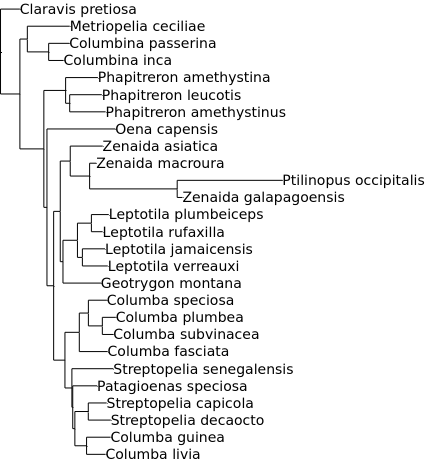

In [13]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0 

ete_tree = Tree( 'RAxML_bestTree.bird' )

ete_tree.set_outgroup('Claravis_pretiosa')

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 10
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)

### Louse tree

In [25]:
louse_records = []

handle = Entrez.esearch(db='nucleotide', term='AF278608:AF278643[accn]' )
record = Entrez.read(handle)
for ntid in record['IdList'] :
    fasta = Entrez.efetch( db='nucleotide', id=ntid, rettype='fasta', retmode='text' ).read()
    louse_dna = parse( StringIO( fasta ), 'fasta' ).next()
    print louse_dna.description
    louse_records.append( louse_dna )
    
handle = Entrez.esearch(db='nucleotide', term='AF190409:AF190426[accn]' )
record = Entrez.read(handle)
for ntid in record['IdList'] :
    fasta = Entrez.efetch( db='nucleotide', id=ntid, rettype='fasta', retmode='text' ).read()
    louse_dna = parse( StringIO( fasta ), 'fasta' ).next()
    print louse_dna.description
    louse_records.append( louse_dna )

AF279704:AF279743
AF278608:AF278643
AY151003:AY151026

AF278643.1 Columbicola baculoides elongation factor 1 alpha gene, partial cds
AF278642.1 Columbicola passerinae haplotype 2 elongation factor 1 alpha gene, partial cds
AF278641.1 Columbicola passerinae haplotype 1 elongation factor 1 alpha gene, partial cds
AF278640.1 Columbicola theresae elongation factor 1 alpha gene, partial cds
AF278639.1 Columbicola gracilicapitis elongation factor 1 alpha gene, partial cds
AF278638.1 Columbicola xavieri elongation factor 1 alpha gene, partial cds
AF278637.1 Columbicola deboomi elongation factor 1 alpha gene, partial cds
AF278636.1 Columbicola columbae haplotype 2 elongation factor 1 alpha gene, partial cds
AF278635.1 Columbicola columbae haplotype 1 elongation factor 1 alpha gene, partial cds
AF278634.1 Columbicola sp. KPJ-2000 elongation factor 1 alpha gene, partial cds
AF278633.1 Columbicola macrourae haplotype 3 elongation factor 1 alpha gene, partial cds
AF278632.1 Columbicola macrourae haplotype 4 elongation factor 1 alpha gene, partial cds


In [66]:
louse_gene_names = { '12S' : '12S ribosomal RNA', 
                     'COI' : 'cytochrome oxidase subunit I',
                     'EF1'  : 'elongation factor' }

louse_genes = {}

for record in louse_records :
    tokens = record.description.split()
    name = [ '_'.join(tokens[1:3]) ]
    if tokens.__contains__( 'haplotype' ) :
        i = tokens.index('haplotype')
        haplotype = '_'.join( tokens[i:i+2] )
        name.append( haplotype )
    name = '_'.join( name )
    
    if not name in louse_genes :
        louse_genes[name] = {}
    
    gene_name = None
    for key in louse_gene_names.keys() :
        if record.description.__contains__( louse_gene_names[key] ) :
            louse_genes[name][key] = record.format('fasta')


louse_genetable = pandas.DataFrame( louse_genes ).T
louse_genetable.applymap( lambda x : len( str2seq(x) ) )

,12S,COI,EF1
Columbicola_adamsi,337,0,328
Columbicola_baculoides,348,386,350
Columbicola_columbae_haplotype_1,335,0,350
Columbicola_columbae_haplotype_2,0,0,350
Columbicola_deboomi,0,0,350
Columbicola_gracilicapitis,343,383,350
Columbicola_macrourae_haplotype_1,349,0,350
Columbicola_macrourae_haplotype_2,339,0,317
Columbicola_macrourae_haplotype_3,339,0,350
Columbicola_macrourae_haplotype_4,0,0,350


In [67]:
# not sure why Erwinia herbicola is in there...
louse_genetable = louse_genetable.drop('Erwinia_herbicola')

In [76]:
for gene in louse_genetable.columns :
    f = open( 'louse_' + gene + '.fasta', 'w' )
    g = louse_genetable[gene].dropna()
    for name, record in g.iteritems() :
        record = parse( StringIO( record ), 'fasta' ).next()
        record.id = name
        record.description = ''
        record.name = ''
        f.write( record.format('fasta') )
    f.close()

In [75]:
!clustalo -v --threads 4 -i louse_12S.fasta        -o louse_12S_aln.fasta
!echo
!clustalo -v --threads 4 -i louse_COI.fasta        -o louse_COI_aln.fasta
!echo
!clustalo -v --threads 4 -i louse_EF1.fasta        -o louse_EF1_aln.fasta
!echo

Using 4 threads
Read 9 sequences (type: DNA) from louse_12S.fasta
not more sequences (9) than cluster-size (100), turn off mBed
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 0.03u 0.00s 00:00:00.03 Elapsed: 00:00:00
Guide-tree computation done.
Progressive alignment progress done. CPU time: 0.64u 0.01s 00:00:00.65 Elapsed: 00:00:00
Alignment written to louse_12S_aln.fasta

Using 4 threads
Read 5 sequences (type: DNA) from louse_COI.fasta
not more sequences (5) than cluster-size (100), turn off mBed
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 0.02u 0.00s 00:00:00.02 Elapsed: 00:00:00
Guide-tree computation done.
Progressive alignment progress done. CPU time: 0.43u 0.00s 00:00:00.43 Elapsed: 00:00:00
Alignment written to louse_COI_aln.fasta

Using 4 threads
Read 15 sequences (type: DNA) from louse_EF1.fasta
not more sequences (15) than cluster-size (100), turn off mBed
Calculating pairwise k

In [77]:
from Bio import AlignIO
from Bio.Nexus import Nexus
from Bio import Alphabet
from glob import glob

nexi = [ (alnfile, Nexus.Nexus( AlignIO.read( alnfile, 'fasta', alphabet=Alphabet.generic_dna  ).format('nexus') ) ) 
          for alnfile in glob( 'louse*_aln.fasta' ) ]
combined = Nexus.combine( nexi )
f = open('louse.nex', 'w')
combined.write_nexus_data(f)
f.close()

# RAxML needs a phylip file
combined.export_phylip('louse.phylip')

'louse.phylip'

In [78]:
# RAxML partition file
f = open( 'louse.txt', 'w' )
for key in combined.charsets.keys() :
    s = 'DNA, ' + key.split('_')[1] + ' = ' + str(combined.charsets[key][0]+1) + '-' + str(combined.charsets[key][-1]+1)
    f.write( s + '\n' )
    print s
f.close()

DNA, 12S = 1-361
DNA, EF1 = 748-1124
DNA, COI = 362-747


In [79]:
!raxmlHPC -m GTRGAMMA -q louse.txt -s louse.phylip -n louse -p 10001

Use raxml with AVX support (2 cpus)

This is the RAxML Master Pthread

This is RAxML Worker Pthread Number: 1


This is RAxML version 8.2.9 released by Alexandros Stamatakis on July 20 2016.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Kassian Kobert    (HITS)
David Dao         (KIT and HITS)
Sarah Lutteropp   (KIT and HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
Charlie Taylor    (UF)


Alignment has 401 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 40.17%

RAxML rapid hill-climbing mode

Using 3 distinct models/data partitions with joint branch length optimization


Executing 1 inferences on the original alignment using 1 distinct randomized MP trees

All free model parameters will be estimated by RAxML
GAMMA model of rate heteorgeneity, ML estimate of alpha-parameter

GAMMA Model parameters will be estimated

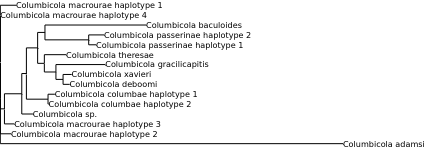

In [80]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0

ete_tree = Tree( 'RAxML_bestTree.louse' )

#ete_tree.set_outgroup('Claravis_pretiosa')

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 10
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)

In [87]:
#map( lambda x : x.replace(' ','_'), bird_genetable.index )
list( louse_genetable.index )

['Columbicola_adamsi',
 'Columbicola_baculoides',
 'Columbicola_columbae_haplotype_1',
 'Columbicola_columbae_haplotype_2',
 'Columbicola_deboomi',
 'Columbicola_gracilicapitis',
 'Columbicola_macrourae_haplotype_1',
 'Columbicola_macrourae_haplotype_2',
 'Columbicola_macrourae_haplotype_3',
 'Columbicola_macrourae_haplotype_4',
 'Columbicola_passerinae_haplotype_1',
 'Columbicola_passerinae_haplotype_2',
 'Columbicola_sp.',
 'Columbicola_theresae',
 'Columbicola_xavieri']

In [ ]:
{'Claravis_pretiosa'         : ['Columbicola_passerinae_haplotype_2'],
 'Columba_guinea'            : ['Columbicola_columbae_haplotype_2'],
 'Columba_livia'             : ['Columbicola_columbae_haplotype_1'],
 'Columba_plumbea'           : ['Columbicola_adamsi'],
 'Columba_speciosa'          : ['Columbicola_adamsi'],
 'Columba_subvinacea'        : [],
 'Columbina_inca'            : [],
 'Columbina_passerina'       : [],
 'Geotrygon_montana'         : [],
 'Leptotila_jamaicensis'     : [],
 'Leptotila_plumbeiceps'     : [],
 'Leptotila_rufaxilla'       : [],
 'Leptotila_verreauxi'       : [],
 'Metriopelia_ceciliae'      : [],
 'Oena_capensis'             : [],
 'Patagioenas_fasciata'      : [],
 'Phapitreron_amethystina'   : [],
 'Phapitreron_leucotis'      : [],
 'Ptilinopus_occipitalis'    : [],
 'Streptopelia_capicola'     : [],
 'Streptopelia_decaocto'     : [],
 'Streptopelia_senegalensis' : [],
 'Zenaida_asiatica'          : [],
 'Zenaida_galapagoensis'     : [],
 'Zenaida_macroura'          : [] }